In [45]:
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.regularizers import l2
import numpy as np


datasets_folder_path = '/content/drive/MyDrive/Colab Notebooks/01.ML/01_cj_project/datasets/img_cls/fm_img_hori/train'

# Define the paths for 'normal' and 'anomaly' folders
normal_folder_path = os.path.join(datasets_folder_path, 'good')
anomaly_folder_path = os.path.join(datasets_folder_path, 'ng')

# Get the list of image files in each folder
normal_images = [f for f in os.listdir(normal_folder_path) if f.endswith('.jpg') or f.endswith('.png')]
anomaly_images = [f for f in os.listdir(anomaly_folder_path) if f.endswith('.jpg') or f.endswith('.png')]


In [46]:
from PIL import Image

# Check the number of images in each folder
num_normal_images = len(normal_images)
num_anomaly_images = len(anomaly_images)

# Load a few sample images to check dimensions and color distribution
sample_normal_image = Image.open(os.path.join(normal_folder_path, normal_images[0]))
sample_anomaly_image = Image.open(os.path.join(anomaly_folder_path, anomaly_images[0]))

sample_normal_image.size, sample_anomaly_image.size


((1024, 1024), (1024, 1024))

In [47]:
# Create a dataframe
image_paths = []
labels = []

for img in os.listdir(normal_folder_path):
    if img.endswith('.jpg') or img.endswith('.png'):
        image_paths.append(os.path.join('good', img))
        labels.append('good')

for img in os.listdir(anomaly_folder_path):
    if img.endswith('.jpg') or img.endswith('.png'):
        image_paths.append(os.path.join('ng', img))
        labels.append('ng')

df = pd.DataFrame({'filename': image_paths, 'class': labels})

In [48]:
df.tail()

,filename,class
914,ng/2022-12-27-163914525.jpg,ng
915,ng/2022-12-27-163921414.jpg,ng
916,ng/2022-12-27-163926678.jpg,ng
917,ng/2022-12-27-163932958.jpg,ng
918,ng/2022-12-27-163938644.jpg,ng


In [49]:
# 학습률 스케줄링 함수
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 10:
        lrate = 0.0005
    if epoch > 20:
        lrate = 0.0003
    return lrate


In [52]:
# 1. 이미지 데이터 생성자 설정
datagen = ImageDataGenerator(rescale=1.0/255,
                             rotation_range=.5,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest',
                             validation_split=0.2)

train_generator = datagen.flow_from_dataframe(
    df,
    directory=datasets_folder_path,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    class_mode='binary',
    batch_size=32,
    subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    df,
    directory=datasets_folder_path,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    class_mode='binary',
    batch_size=32,
    subset='validation'
)


Found 736 validated image filenames belonging to 2 classes.
Found 183 validated image filenames belonging to 2 classes.


In [53]:

# 2. MobileNetV2 모델 불러오기
# base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 3. 새로운 헤더 추가
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(.2)(x)

# 'num_classes'를 구하기 위한 코드 수정
    # num_classes = len(train_generator.class_indices)  # 클래스 수를 얻습니다.
# 'num_classes'를 구하기 위한 코드 수정
num_classes = len(train_generator.class_indices)  # 클래스 수를 얻습니다.
print("Number of classes:", num_classes)


predictions = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.01))(x)  # L2 정규화 적용
model = Model(inputs=base_model.input, outputs=predictions)

# 4. 모델 컴파일
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy',Precision()])
# model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy', Precision()])

# Early Stopping 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=3)


# 5. 모델 학습
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=15,  # 실제로는 더 많은 epoch를 사용할 수 있습니다.
    callbacks = [early_stopping,LearningRateScheduler(lr_schedule)]
)

Number of classes: 2
Epoch 1/15


ValueError: ignored

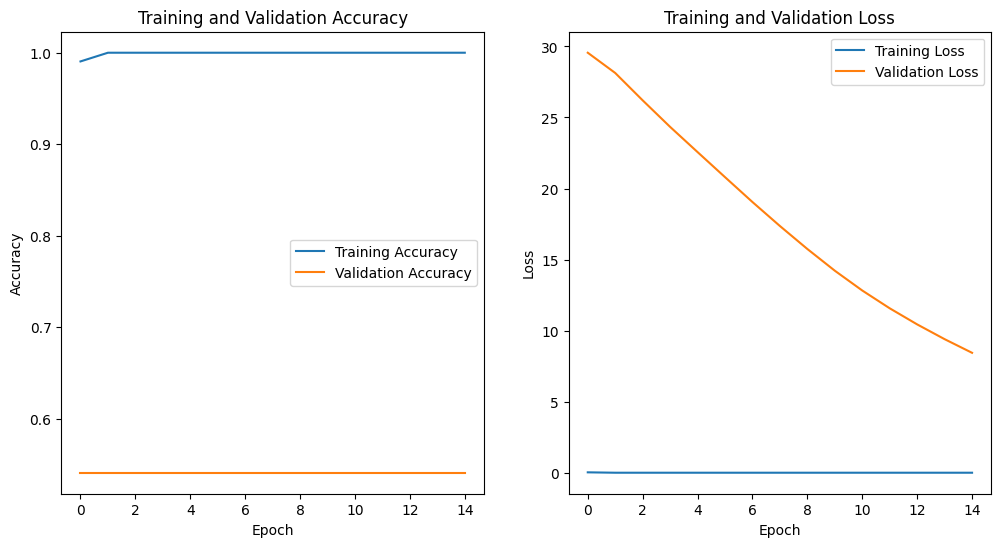

In [19]:
import matplotlib.pyplot as plt

# 1. 학습률과 손실률 그래프 그리기
# "History" 객체에는 학습 중 발생한 모든 정보가 저장되어 있습니다.
# 여기에는 훈련 정확도와 검증 정확도, 훈련 손실과 검증 손실이 포함됩니다.

# Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()




In [ ]:
# 2. 테스트 데이터 성능 평가
# 테스트 데이터를 로드하고 모델 성능을 평가합니다.
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(
    'test_data_directory',  # 실제 테스트 데이터 폴더를 입력하세요.
    target_size=(512, 512),
    batch_size=32,
    class_mode='categorical'
)

# 모델 성능 평가
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")